# MONAI : Tutorial : 3d_segmentation
## Spleen 3D segmentation with MONAI

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb
- https://www.classcat.com/medical_ai/2023/01/19/monai-1-0-tutorials-3d-segmentation-spleen/

## 0. 準備

In [1]:
# パッケージのインストール
#!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
#!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
# パッケージのインポート
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/monai/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.26.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installi

In [3]:
# 乱数シード設定
set_determinism(seed=2023)

In [4]:
root_dir = os.path.realpath('./MSD')
print(root_dir)

/data1/Datasets/MSD


In [5]:
# データダウンロード
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, 'Task09_Spleen.tar')
data_dir = os.path.join(root_dir, 'Task09_Spleen')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [6]:
train_images = sorted(glob(os.path.join(data_dir, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'labelsTr', '*.nii.gz')))

data_dicts = [
    {'image': image_name, 'label': label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## 1. データセット, データローダ

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest')),
        RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), 
                               pos=1, neg=1, num_samples=4, image_key='image', image_threshold=0,),
    ]
)

In [8]:
val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest')),
    ]
)

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


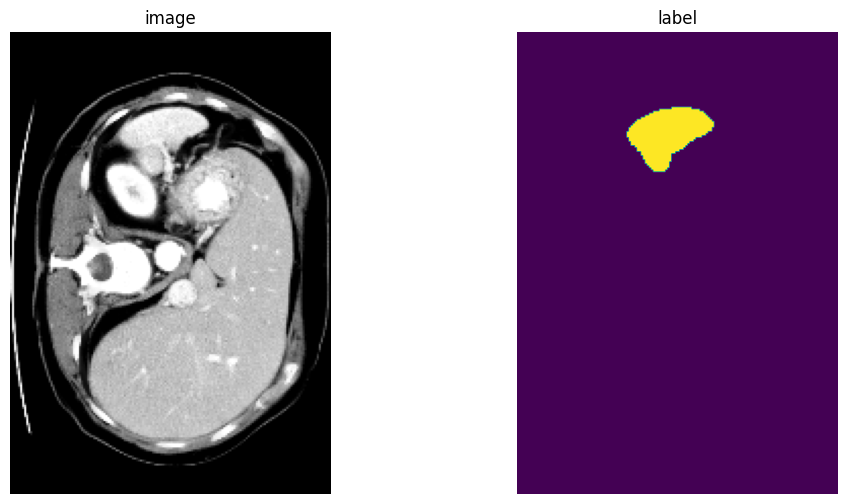

In [9]:
# transformsのチェック
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data['image'][0][0], check_data['label'][0][0])
print(f'image shape: {image.shape}, label shape: {label.shape}')

# plot the slice [:, :, 80]
plt.figure('check', figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 80], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 80])
plt.axis('off')
plt.show()

In [10]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:04<00:00,  1.88it/s]


## 2. モデル構築

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [13]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction='mean')

## 3. 学習
### 3.1 モデルの学習

In [14]:
model_dir = './models/spleen_seg'
os.makedirs(model_dir, exist_ok=True)

max_epochs = 600
val_interval = 2

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

In [15]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# epochループ
for epoch in range(max_epochs):
    print('-' * 10)
    print(f'epoch {epoch + 1}/{max_epochs}')
    model.train()
    epoch_loss = 0
    step = 0
    
    # mini batchループ
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data['image'].to(device),
            batch_data['label'].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f'{step}/{len(train_ds) // train_loader.batch_size}, '
            f'train_loss: {loss.item():.4f}')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch {epoch + 1} average loss: {epoch_loss:.4f}')
    
    # 評価
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data['image'].to(device),
                    val_data['label'].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(model_dir, 'best_metric_model.pth'))
                print('save new best metric model')
            print(
                f'current epoch: {epoch + 1} current mean dice: {metric:.4f}'
                f'\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}'
            )

print(
    f'train completed, best metric: {best_metric:.4f} '
    f'at epoch: {best_metric_epoch}')

----------
epoch 1/600
1/16, train_loss: 0.6389
2/16, train_loss: 0.6331
3/16, train_loss: 0.6208
4/16, train_loss: 0.6282
5/16, train_loss: 0.6232
6/16, train_loss: 0.6060
7/16, train_loss: 0.6265
8/16, train_loss: 0.6058
9/16, train_loss: 0.5892
10/16, train_loss: 0.6065
11/16, train_loss: 0.6170
12/16, train_loss: 0.6116
13/16, train_loss: 0.6182
14/16, train_loss: 0.6186
15/16, train_loss: 0.6160
16/16, train_loss: 0.5992
epoch 1 average loss: 0.6162
----------
epoch 2/600
1/16, train_loss: 0.6337
2/16, train_loss: 0.6131
3/16, train_loss: 0.6220
4/16, train_loss: 0.6088
5/16, train_loss: 0.6095
6/16, train_loss: 0.6306
7/16, train_loss: 0.5977
8/16, train_loss: 0.5937
9/16, train_loss: 0.5930
10/16, train_loss: 0.6120
11/16, train_loss: 0.5941
12/16, train_loss: 0.6193
13/16, train_loss: 0.6153
14/16, train_loss: 0.5656
15/16, train_loss: 0.6039
16/16, train_loss: 0.5751
epoch 2 average loss: 0.6054
save new best metric model
current epoch: 2 current mean dice: 0.0551
best mean di

7/16, train_loss: 0.4784
8/16, train_loss: 0.4887
9/16, train_loss: 0.4384
10/16, train_loss: 0.4913
11/16, train_loss: 0.4557
12/16, train_loss: 0.4387
13/16, train_loss: 0.4913
14/16, train_loss: 0.4262
15/16, train_loss: 0.4911
16/16, train_loss: 0.5085
epoch 17 average loss: 0.4690
----------
epoch 18/600
1/16, train_loss: 0.4235
2/16, train_loss: 0.4588
3/16, train_loss: 0.4470
4/16, train_loss: 0.4771
5/16, train_loss: 0.4638
6/16, train_loss: 0.4607
7/16, train_loss: 0.4687
8/16, train_loss: 0.4321
9/16, train_loss: 0.4370
10/16, train_loss: 0.4841
11/16, train_loss: 0.5521
12/16, train_loss: 0.4108
13/16, train_loss: 0.4494
14/16, train_loss: 0.4680
15/16, train_loss: 0.4598
16/16, train_loss: 0.4960
epoch 18 average loss: 0.4618
current epoch: 18 current mean dice: 0.0689
best mean dice: 0.1093 at epoch: 6
----------
epoch 19/600
1/16, train_loss: 0.4122
2/16, train_loss: 0.4806
3/16, train_loss: 0.4061
4/16, train_loss: 0.4618
5/16, train_loss: 0.4036
6/16, train_loss: 0.4567

16/16, train_loss: 0.3689
epoch 33 average loss: 0.3425
----------
epoch 34/600
1/16, train_loss: 0.4062
2/16, train_loss: 0.2547
3/16, train_loss: 0.3210
4/16, train_loss: 0.3091
5/16, train_loss: 0.3216
6/16, train_loss: 0.3213
7/16, train_loss: 0.3596
8/16, train_loss: 0.4217
9/16, train_loss: 0.2427
10/16, train_loss: 0.3214
11/16, train_loss: 0.4129
12/16, train_loss: 0.3385
13/16, train_loss: 0.4495
14/16, train_loss: 0.3535
15/16, train_loss: 0.3927
16/16, train_loss: 0.2785
epoch 34 average loss: 0.3441
save new best metric model
current epoch: 34 current mean dice: 0.1429
best mean dice: 0.1429 at epoch: 34
----------
epoch 35/600
1/16, train_loss: 0.3349
2/16, train_loss: 0.3482
3/16, train_loss: 0.3450
4/16, train_loss: 0.3082
5/16, train_loss: 0.3921
6/16, train_loss: 0.3752
7/16, train_loss: 0.4049
8/16, train_loss: 0.4120
9/16, train_loss: 0.2557
10/16, train_loss: 0.2973
11/16, train_loss: 0.2844
12/16, train_loss: 0.3014
13/16, train_loss: 0.4997
14/16, train_loss: 0.31

4/16, train_loss: 0.2696
5/16, train_loss: 0.1701
6/16, train_loss: 0.2431
7/16, train_loss: 0.2147
8/16, train_loss: 0.3075
9/16, train_loss: 0.3024
10/16, train_loss: 0.2683
11/16, train_loss: 0.2291
12/16, train_loss: 0.2685
13/16, train_loss: 0.2535
14/16, train_loss: 0.3336
15/16, train_loss: 0.2031
16/16, train_loss: 0.2356
epoch 50 average loss: 0.2611
current epoch: 50 current mean dice: 0.0577
best mean dice: 0.1429 at epoch: 34
----------
epoch 51/600
1/16, train_loss: 0.2689
2/16, train_loss: 0.3535
3/16, train_loss: 0.4086
4/16, train_loss: 0.2864
5/16, train_loss: 0.2546
6/16, train_loss: 0.3151
7/16, train_loss: 0.2591
8/16, train_loss: 0.3049
9/16, train_loss: 0.1896
10/16, train_loss: 0.2041
11/16, train_loss: 0.3137
12/16, train_loss: 0.2493
13/16, train_loss: 0.2309
14/16, train_loss: 0.1587
15/16, train_loss: 0.1838
16/16, train_loss: 0.2804
epoch 51 average loss: 0.2664
----------
epoch 52/600
1/16, train_loss: 0.1956
2/16, train_loss: 0.3708
3/16, train_loss: 0.324

11/16, train_loss: 0.2796
12/16, train_loss: 0.2535
13/16, train_loss: 0.3045
14/16, train_loss: 0.3146
15/16, train_loss: 0.1933
16/16, train_loss: 0.2938
epoch 66 average loss: 0.2370
save new best metric model
current epoch: 66 current mean dice: 0.4063
best mean dice: 0.4063 at epoch: 66
----------
epoch 67/600
1/16, train_loss: 0.2091
2/16, train_loss: 0.2424
3/16, train_loss: 0.3131
4/16, train_loss: 0.1519
5/16, train_loss: 0.2338
6/16, train_loss: 0.1290
7/16, train_loss: 0.3527
8/16, train_loss: 0.1667
9/16, train_loss: 0.3435
10/16, train_loss: 0.1294
11/16, train_loss: 0.2445
12/16, train_loss: 0.1834
13/16, train_loss: 0.2363
14/16, train_loss: 0.1715
15/16, train_loss: 0.3383
16/16, train_loss: 0.1581
epoch 67 average loss: 0.2252
----------
epoch 68/600
1/16, train_loss: 0.2931
2/16, train_loss: 0.1665
3/16, train_loss: 0.2902
4/16, train_loss: 0.2300
5/16, train_loss: 0.1799
6/16, train_loss: 0.1577
7/16, train_loss: 0.1684
8/16, train_loss: 0.1782
9/16, train_loss: 0.22

13/16, train_loss: 0.2166
14/16, train_loss: 0.1739
15/16, train_loss: 0.1600
16/16, train_loss: 0.1101
epoch 82 average loss: 0.1907
current epoch: 82 current mean dice: 0.8895
best mean dice: 0.9157 at epoch: 74
----------
epoch 83/600
1/16, train_loss: 0.1601
2/16, train_loss: 0.2782
3/16, train_loss: 0.2081
4/16, train_loss: 0.4481
5/16, train_loss: 0.2169
6/16, train_loss: 0.1857
7/16, train_loss: 0.1796
8/16, train_loss: 0.2754
9/16, train_loss: 0.0509
10/16, train_loss: 0.1260
11/16, train_loss: 0.1786
12/16, train_loss: 0.1836
13/16, train_loss: 0.1780
14/16, train_loss: 0.3942
15/16, train_loss: 0.1633
16/16, train_loss: 0.2827
epoch 83 average loss: 0.2193
----------
epoch 84/600
1/16, train_loss: 0.3377
2/16, train_loss: 0.2729
3/16, train_loss: 0.1120
4/16, train_loss: 0.1658
5/16, train_loss: 0.2724
6/16, train_loss: 0.1098
7/16, train_loss: 0.1954
8/16, train_loss: 0.2666
9/16, train_loss: 0.1574
10/16, train_loss: 0.2122
11/16, train_loss: 0.2351
12/16, train_loss: 0.166

1/16, train_loss: 0.2170
2/16, train_loss: 0.2816
3/16, train_loss: 0.1552
4/16, train_loss: 0.1901
5/16, train_loss: 0.3906
6/16, train_loss: 0.2170
7/16, train_loss: 0.1549
8/16, train_loss: 0.3300
9/16, train_loss: 0.0827
10/16, train_loss: 0.2130
11/16, train_loss: 0.2693
12/16, train_loss: 0.2062
13/16, train_loss: 0.1158
14/16, train_loss: 0.2146
15/16, train_loss: 0.1699
16/16, train_loss: 0.1552
epoch 99 average loss: 0.2102
----------
epoch 100/600
1/16, train_loss: 0.2329
2/16, train_loss: 0.2137
3/16, train_loss: 0.1783
4/16, train_loss: 0.0984
5/16, train_loss: 0.3272
6/16, train_loss: 0.2718
7/16, train_loss: 0.2703
8/16, train_loss: 0.2467
9/16, train_loss: 0.1023
10/16, train_loss: 0.3295
11/16, train_loss: 0.2056
12/16, train_loss: 0.3287
13/16, train_loss: 0.2097
14/16, train_loss: 0.3869
15/16, train_loss: 0.2321
16/16, train_loss: 0.2339
epoch 100 average loss: 0.2418
current epoch: 100 current mean dice: 0.8193
best mean dice: 0.9170 at epoch: 94
----------
epoch 10

5/16, train_loss: 0.2702
6/16, train_loss: 0.1558
7/16, train_loss: 0.2168
8/16, train_loss: 0.1025
9/16, train_loss: 0.1732
10/16, train_loss: 0.1441
11/16, train_loss: 0.1130
12/16, train_loss: 0.3293
13/16, train_loss: 0.2082
14/16, train_loss: 0.3274
15/16, train_loss: 0.0933
16/16, train_loss: 0.1500
epoch 115 average loss: 0.1896
----------
epoch 116/600
1/16, train_loss: 0.2507
2/16, train_loss: 0.3283
3/16, train_loss: 0.1156
4/16, train_loss: 0.1452
5/16, train_loss: 0.2635
6/16, train_loss: 0.2097
7/16, train_loss: 0.2686
8/16, train_loss: 0.2732
9/16, train_loss: 0.2944
10/16, train_loss: 0.3266
11/16, train_loss: 0.3871
12/16, train_loss: 0.2086
13/16, train_loss: 0.2973
14/16, train_loss: 0.2101
15/16, train_loss: 0.2717
16/16, train_loss: 0.2305
epoch 116 average loss: 0.2551
current epoch: 116 current mean dice: 0.9180
best mean dice: 0.9365 at epoch: 108
----------
epoch 117/600
1/16, train_loss: 0.1487
2/16, train_loss: 0.1575
3/16, train_loss: 0.3238
4/16, train_loss:

9/16, train_loss: 0.0411
10/16, train_loss: 0.3327
11/16, train_loss: 0.2217
12/16, train_loss: 0.2600
13/16, train_loss: 0.1510
14/16, train_loss: 0.2148
15/16, train_loss: 0.2814
16/16, train_loss: 0.2673
epoch 131 average loss: 0.1800
----------
epoch 132/600
1/16, train_loss: 0.0938
2/16, train_loss: 0.1536
3/16, train_loss: 0.1512
4/16, train_loss: 0.1291
5/16, train_loss: 0.2727
6/16, train_loss: 0.3176
7/16, train_loss: 0.0954
8/16, train_loss: 0.3343
9/16, train_loss: 0.2170
10/16, train_loss: 0.0895
11/16, train_loss: 0.2688
12/16, train_loss: 0.1464
13/16, train_loss: 0.1019
14/16, train_loss: 0.3385
15/16, train_loss: 0.2172
16/16, train_loss: 0.4106
epoch 132 average loss: 0.2086
current epoch: 132 current mean dice: 0.8441
best mean dice: 0.9373 at epoch: 122
----------
epoch 133/600
1/16, train_loss: 0.1541
2/16, train_loss: 0.1592
3/16, train_loss: 0.1553
4/16, train_loss: 0.2690
5/16, train_loss: 0.2847
6/16, train_loss: 0.0982
7/16, train_loss: 0.2118
8/16, train_loss:

13/16, train_loss: 0.1490
14/16, train_loss: 0.0914
15/16, train_loss: 0.2447
16/16, train_loss: 0.0502
epoch 147 average loss: 0.1514
----------
epoch 148/600
1/16, train_loss: 0.1510
2/16, train_loss: 0.1551
3/16, train_loss: 0.2484
4/16, train_loss: 0.2097
5/16, train_loss: 0.2643
6/16, train_loss: 0.1625
7/16, train_loss: 0.2270
8/16, train_loss: 0.2762
9/16, train_loss: 0.2719
10/16, train_loss: 0.3222
11/16, train_loss: 0.3257
12/16, train_loss: 0.1541
13/16, train_loss: 0.2633
14/16, train_loss: 0.2081
15/16, train_loss: 0.1510
16/16, train_loss: 0.2049
epoch 148 average loss: 0.2247
current epoch: 148 current mean dice: 0.9110
best mean dice: 0.9414 at epoch: 146
----------
epoch 149/600
1/16, train_loss: 0.2667
2/16, train_loss: 0.3394
3/16, train_loss: 0.1448
4/16, train_loss: 0.0920
5/16, train_loss: 0.2043
6/16, train_loss: 0.1608
7/16, train_loss: 0.2056
8/16, train_loss: 0.2647
9/16, train_loss: 0.1701
10/16, train_loss: 0.3164
11/16, train_loss: 0.2638
12/16, train_loss:

15/16, train_loss: 0.0838
16/16, train_loss: 0.2045
epoch 163 average loss: 0.1870
----------
epoch 164/600
1/16, train_loss: 0.0939
2/16, train_loss: 0.0914
3/16, train_loss: 0.2638
4/16, train_loss: 0.3825
5/16, train_loss: 0.2041
6/16, train_loss: 0.2122
7/16, train_loss: 0.1512
8/16, train_loss: 0.1477
9/16, train_loss: 0.0990
10/16, train_loss: 0.3074
11/16, train_loss: 0.1108
12/16, train_loss: 0.2629
13/16, train_loss: 0.2092
14/16, train_loss: 0.0971
15/16, train_loss: 0.2058
16/16, train_loss: 0.2638
epoch 164 average loss: 0.1939
current epoch: 164 current mean dice: 0.9402
best mean dice: 0.9466 at epoch: 160
----------
epoch 165/600
1/16, train_loss: 0.1467
2/16, train_loss: 0.1445
3/16, train_loss: 0.1893
4/16, train_loss: 0.2015
5/16, train_loss: 0.0861
6/16, train_loss: 0.3000
7/16, train_loss: 0.2657
8/16, train_loss: 0.2742
9/16, train_loss: 0.2032
10/16, train_loss: 0.2147
11/16, train_loss: 0.2675
12/16, train_loss: 0.1468
13/16, train_loss: 0.1447
14/16, train_loss:

2/16, train_loss: 0.1493
3/16, train_loss: 0.1500
4/16, train_loss: 0.2086
5/16, train_loss: 0.2206
6/16, train_loss: 0.0830
7/16, train_loss: 0.1681
8/16, train_loss: 0.1505
9/16, train_loss: 0.2072
10/16, train_loss: 0.2641
11/16, train_loss: 0.2088
12/16, train_loss: 0.2060
13/16, train_loss: 0.0236
14/16, train_loss: 0.3230
15/16, train_loss: 0.2716
16/16, train_loss: 0.1186
epoch 180 average loss: 0.1816
current epoch: 180 current mean dice: 0.9149
best mean dice: 0.9466 at epoch: 160
----------
epoch 181/600
1/16, train_loss: 0.2097
2/16, train_loss: 0.1580
3/16, train_loss: 0.0844
4/16, train_loss: 0.2629
5/16, train_loss: 0.2643
6/16, train_loss: 0.1128
7/16, train_loss: 0.2636
8/16, train_loss: 0.1463
9/16, train_loss: 0.2145
10/16, train_loss: 0.2035
11/16, train_loss: 0.0931
12/16, train_loss: 0.1492
13/16, train_loss: 0.2630
14/16, train_loss: 0.2156
15/16, train_loss: 0.2051
16/16, train_loss: 0.2018
epoch 181 average loss: 0.1905
----------
epoch 182/600
1/16, train_loss:

9/16, train_loss: 0.2682
10/16, train_loss: 0.2753
11/16, train_loss: 0.2662
12/16, train_loss: 0.2090
13/16, train_loss: 0.1513
14/16, train_loss: 0.2090
15/16, train_loss: 0.1562
16/16, train_loss: 0.0739
epoch 196 average loss: 0.2181
current epoch: 196 current mean dice: 0.8170
best mean dice: 0.9466 at epoch: 160
----------
epoch 197/600
1/16, train_loss: 0.1524
2/16, train_loss: 0.2142
3/16, train_loss: 0.2628
4/16, train_loss: 0.1479
5/16, train_loss: 0.1613
6/16, train_loss: 0.2749
7/16, train_loss: 0.1486
8/16, train_loss: 0.0923
9/16, train_loss: 0.2716
10/16, train_loss: 0.2047
11/16, train_loss: 0.3379
12/16, train_loss: 0.3238
13/16, train_loss: 0.2654
14/16, train_loss: 0.3141
15/16, train_loss: 0.1514
16/16, train_loss: 0.3309
epoch 197 average loss: 0.2284
----------
epoch 198/600
1/16, train_loss: 0.0867
2/16, train_loss: 0.0864
3/16, train_loss: 0.1000
4/16, train_loss: 0.2285
5/16, train_loss: 0.0918
6/16, train_loss: 0.2691
7/16, train_loss: 0.1500
8/16, train_loss:

14/16, train_loss: 0.1445
15/16, train_loss: 0.1300
16/16, train_loss: 0.2719
epoch 212 average loss: 0.2083
current epoch: 212 current mean dice: 0.9425
best mean dice: 0.9466 at epoch: 160
----------
epoch 213/600
1/16, train_loss: 0.2643
2/16, train_loss: 0.1523
3/16, train_loss: 0.1231
4/16, train_loss: 0.0849
5/16, train_loss: 0.2022
6/16, train_loss: 0.2615
7/16, train_loss: 0.2051
8/16, train_loss: 0.1431
9/16, train_loss: 0.0886
10/16, train_loss: 0.0884
11/16, train_loss: 0.0843
12/16, train_loss: 0.0919
13/16, train_loss: 0.2012
14/16, train_loss: 0.1456
15/16, train_loss: 0.3843
16/16, train_loss: 0.1214
epoch 213 average loss: 0.1651
----------
epoch 214/600
1/16, train_loss: 0.1432
2/16, train_loss: 0.1452
3/16, train_loss: 0.2187
4/16, train_loss: 0.2145
5/16, train_loss: 0.2189
6/16, train_loss: 0.1080
7/16, train_loss: 0.2219
8/16, train_loss: 0.2043
9/16, train_loss: 0.1636
10/16, train_loss: 0.0868
11/16, train_loss: 0.1752
12/16, train_loss: 0.2665
13/16, train_loss:

1/16, train_loss: 0.1452
2/16, train_loss: 0.0947
3/16, train_loss: 0.0886
4/16, train_loss: 0.1495
5/16, train_loss: 0.2687
6/16, train_loss: 0.3225
7/16, train_loss: 0.2673
8/16, train_loss: 0.2543
9/16, train_loss: 0.0310
10/16, train_loss: 0.2703
11/16, train_loss: 0.2641
12/16, train_loss: 0.0900
13/16, train_loss: 0.2653
14/16, train_loss: 0.1440
15/16, train_loss: 0.2000
16/16, train_loss: 0.3267
epoch 229 average loss: 0.1989
----------
epoch 230/600
1/16, train_loss: 0.0239
2/16, train_loss: 0.0877
3/16, train_loss: 0.2484
4/16, train_loss: 0.2531
5/16, train_loss: 0.2050
6/16, train_loss: 0.2014
7/16, train_loss: 0.3021
8/16, train_loss: 0.2054
9/16, train_loss: 0.1442
10/16, train_loss: 0.2301
11/16, train_loss: 0.0236
12/16, train_loss: 0.1474
13/16, train_loss: 0.1780
14/16, train_loss: 0.2073
15/16, train_loss: 0.1922
16/16, train_loss: 0.2042
epoch 230 average loss: 0.1784
current epoch: 230 current mean dice: 0.8874
best mean dice: 0.9466 at epoch: 160
----------
epoch 

7/16, train_loss: 0.1459
8/16, train_loss: 0.2141
9/16, train_loss: 0.2750
10/16, train_loss: 0.2177
11/16, train_loss: 0.1463
12/16, train_loss: 0.0861
13/16, train_loss: 0.3264
14/16, train_loss: 0.0873
15/16, train_loss: 0.2038
16/16, train_loss: 0.2019
epoch 245 average loss: 0.1854
----------
epoch 246/600
1/16, train_loss: 0.0881
2/16, train_loss: 0.1480
3/16, train_loss: 0.1571
4/16, train_loss: 0.2662
5/16, train_loss: 0.3192
6/16, train_loss: 0.0968
7/16, train_loss: 0.0907
8/16, train_loss: 0.2083
9/16, train_loss: 0.0914
10/16, train_loss: 0.0836
11/16, train_loss: 0.3239
12/16, train_loss: 0.2722
13/16, train_loss: 0.2113
14/16, train_loss: 0.1415
15/16, train_loss: 0.1414
16/16, train_loss: 0.0349
epoch 246 average loss: 0.1672
current epoch: 246 current mean dice: 0.8784
best mean dice: 0.9466 at epoch: 160
----------
epoch 247/600
1/16, train_loss: 0.2105
2/16, train_loss: 0.1486
3/16, train_loss: 0.0873
4/16, train_loss: 0.0865
5/16, train_loss: 0.2633
6/16, train_loss:

13/16, train_loss: 0.0863
14/16, train_loss: 0.2104
15/16, train_loss: 0.1472
16/16, train_loss: 0.2803
epoch 261 average loss: 0.1843
----------
epoch 262/600
1/16, train_loss: 0.2627
2/16, train_loss: 0.2651
3/16, train_loss: 0.1446
4/16, train_loss: 0.1778
5/16, train_loss: 0.3825
6/16, train_loss: 0.2029
7/16, train_loss: 0.2031
8/16, train_loss: 0.1828
9/16, train_loss: 0.1484
10/16, train_loss: 0.2913
11/16, train_loss: 0.2097
12/16, train_loss: 0.2662
13/16, train_loss: 0.2098
14/16, train_loss: 0.1715
15/16, train_loss: 0.2126
16/16, train_loss: 0.0284
epoch 262 average loss: 0.2100
current epoch: 262 current mean dice: 0.9196
best mean dice: 0.9466 at epoch: 160
----------
epoch 263/600
1/16, train_loss: 0.0938
2/16, train_loss: 0.2036
3/16, train_loss: 0.1569
4/16, train_loss: 0.1422
5/16, train_loss: 0.1452
6/16, train_loss: 0.2595
7/16, train_loss: 0.1401
8/16, train_loss: 0.2668
9/16, train_loss: 0.1654
10/16, train_loss: 0.2155
11/16, train_loss: 0.3244
12/16, train_loss:

16/16, train_loss: 0.0369
epoch 277 average loss: 0.1912
----------
epoch 278/600
1/16, train_loss: 0.2124
2/16, train_loss: 0.2238
3/16, train_loss: 0.2434
4/16, train_loss: 0.2379
5/16, train_loss: 0.2646
6/16, train_loss: 0.2054
7/16, train_loss: 0.3020
8/16, train_loss: 0.2714
9/16, train_loss: 0.1413
10/16, train_loss: 0.1400
11/16, train_loss: 0.2677
12/16, train_loss: 0.4407
13/16, train_loss: 0.2043
14/16, train_loss: 0.3589
15/16, train_loss: 0.2068
16/16, train_loss: 0.2022
epoch 278 average loss: 0.2452
current epoch: 278 current mean dice: 0.8572
best mean dice: 0.9482 at epoch: 274
----------
epoch 279/600
1/16, train_loss: 0.1428
2/16, train_loss: 0.2051
3/16, train_loss: 0.2036
4/16, train_loss: 0.2052
5/16, train_loss: 0.1557
6/16, train_loss: 0.2050
7/16, train_loss: 0.0866
8/16, train_loss: 0.2690
9/16, train_loss: 0.1509
10/16, train_loss: 0.1443
11/16, train_loss: 0.1005
12/16, train_loss: 0.0357
13/16, train_loss: 0.0894
14/16, train_loss: 0.2606
15/16, train_loss:

3/16, train_loss: 0.1407
4/16, train_loss: 0.2046
5/16, train_loss: 0.1404
6/16, train_loss: 0.0832
7/16, train_loss: 0.2179
8/16, train_loss: 0.1407
9/16, train_loss: 0.0792
10/16, train_loss: 0.1457
11/16, train_loss: 0.1762
12/16, train_loss: 0.1211
13/16, train_loss: 0.2001
14/16, train_loss: 0.2026
15/16, train_loss: 0.2616
16/16, train_loss: 0.1800
epoch 294 average loss: 0.1652
current epoch: 294 current mean dice: 0.9427
best mean dice: 0.9482 at epoch: 274
----------
epoch 295/600
1/16, train_loss: 0.1677
2/16, train_loss: 0.1474
3/16, train_loss: 0.0227
4/16, train_loss: 0.3832
5/16, train_loss: 0.2008
6/16, train_loss: 0.1421
7/16, train_loss: 0.1472
8/16, train_loss: 0.0977
9/16, train_loss: 0.0231
10/16, train_loss: 0.0259
11/16, train_loss: 0.2647
12/16, train_loss: 0.0845
13/16, train_loss: 0.1601
14/16, train_loss: 0.2007
15/16, train_loss: 0.2006
16/16, train_loss: 0.2604
epoch 295 average loss: 0.1580
----------
epoch 296/600
1/16, train_loss: 0.2065
2/16, train_loss:

9/16, train_loss: 0.0317
10/16, train_loss: 0.2084
11/16, train_loss: 0.2647
12/16, train_loss: 0.0817
13/16, train_loss: 0.1452
14/16, train_loss: 0.2603
15/16, train_loss: 0.2093
16/16, train_loss: 0.2007
epoch 310 average loss: 0.2001
current epoch: 310 current mean dice: 0.9439
best mean dice: 0.9482 at epoch: 274
----------
epoch 311/600
1/16, train_loss: 0.1626
2/16, train_loss: 0.0848
3/16, train_loss: 0.1499
4/16, train_loss: 0.1445
5/16, train_loss: 0.0824
6/16, train_loss: 0.2013
7/16, train_loss: 0.2063
8/16, train_loss: 0.1435
9/16, train_loss: 0.3217
10/16, train_loss: 0.1993
11/16, train_loss: 0.1043
12/16, train_loss: 0.2017
13/16, train_loss: 0.1419
14/16, train_loss: 0.0995
15/16, train_loss: 0.2001
16/16, train_loss: 0.1412
epoch 311 average loss: 0.1616
----------
epoch 312/600
1/16, train_loss: 0.1125
2/16, train_loss: 0.0823
3/16, train_loss: 0.1500
4/16, train_loss: 0.1409
5/16, train_loss: 0.2603
6/16, train_loss: 0.3287
7/16, train_loss: 0.1157
8/16, train_loss:

14/16, train_loss: 0.3208
15/16, train_loss: 0.1409
16/16, train_loss: 0.1601
epoch 326 average loss: 0.1703
current epoch: 326 current mean dice: 0.9480
best mean dice: 0.9482 at epoch: 274
----------
epoch 327/600
1/16, train_loss: 0.2606
2/16, train_loss: 0.3205
3/16, train_loss: 0.2097
4/16, train_loss: 0.0897
5/16, train_loss: 0.1187
6/16, train_loss: 0.0833
7/16, train_loss: 0.2137
8/16, train_loss: 0.1406
9/16, train_loss: 0.0878
10/16, train_loss: 0.3241
11/16, train_loss: 0.2005
12/16, train_loss: 0.1419
13/16, train_loss: 0.3812
14/16, train_loss: 0.0876
15/16, train_loss: 0.0828
16/16, train_loss: 0.1427
epoch 327 average loss: 0.1803
----------
epoch 328/600
1/16, train_loss: 0.3291
2/16, train_loss: 0.3210
3/16, train_loss: 0.1438
4/16, train_loss: 0.0780
5/16, train_loss: 0.2013
6/16, train_loss: 0.0861
7/16, train_loss: 0.0827
8/16, train_loss: 0.2627
9/16, train_loss: 0.2617
10/16, train_loss: 0.2675
11/16, train_loss: 0.2080
12/16, train_loss: 0.0859
13/16, train_loss:

1/16, train_loss: 0.2629
2/16, train_loss: 0.3489
3/16, train_loss: 0.0823
4/16, train_loss: 0.3209
5/16, train_loss: 0.2590
6/16, train_loss: 0.3243
7/16, train_loss: 0.2106
8/16, train_loss: 0.2021
9/16, train_loss: 0.0300
10/16, train_loss: 0.0923
11/16, train_loss: 0.2045
12/16, train_loss: 0.2379
13/16, train_loss: 0.2590
14/16, train_loss: 0.2042
15/16, train_loss: 0.1431
16/16, train_loss: 0.1426
epoch 343 average loss: 0.2078
----------
epoch 344/600
1/16, train_loss: 0.2713
2/16, train_loss: 0.2604
3/16, train_loss: 0.0288
4/16, train_loss: 0.2649
5/16, train_loss: 0.2040
6/16, train_loss: 0.1420
7/16, train_loss: 0.0882
8/16, train_loss: 0.1393
9/16, train_loss: 0.2007
10/16, train_loss: 0.0906
11/16, train_loss: 0.0216
12/16, train_loss: 0.0353
13/16, train_loss: 0.2614
14/16, train_loss: 0.1700
15/16, train_loss: 0.1416
16/16, train_loss: 0.2031
epoch 344 average loss: 0.1577
current epoch: 344 current mean dice: 0.9350
best mean dice: 0.9482 at epoch: 274
----------
epoch 

8/16, train_loss: 0.0218
9/16, train_loss: 0.2053
10/16, train_loss: 0.1060
11/16, train_loss: 0.0905
12/16, train_loss: 0.1469
13/16, train_loss: 0.2589
14/16, train_loss: 0.1994
15/16, train_loss: 0.3799
16/16, train_loss: 0.0826
epoch 359 average loss: 0.1716
----------
epoch 360/600
1/16, train_loss: 0.1585
2/16, train_loss: 0.1407
3/16, train_loss: 0.2615
4/16, train_loss: 0.1394
5/16, train_loss: 0.0904
6/16, train_loss: 0.0244
7/16, train_loss: 0.0976
8/16, train_loss: 0.2002
9/16, train_loss: 0.1417
10/16, train_loss: 0.1418
11/16, train_loss: 0.2011
12/16, train_loss: 0.1607
13/16, train_loss: 0.2624
14/16, train_loss: 0.1370
15/16, train_loss: 0.1567
16/16, train_loss: 0.1522
epoch 360 average loss: 0.1541
current epoch: 360 current mean dice: 0.9379
best mean dice: 0.9482 at epoch: 274
----------
epoch 361/600
1/16, train_loss: 0.4387
2/16, train_loss: 0.2055
3/16, train_loss: 0.2039
4/16, train_loss: 0.0253
5/16, train_loss: 0.1992
6/16, train_loss: 0.1422
7/16, train_loss:

13/16, train_loss: 0.1997
14/16, train_loss: 0.0895
15/16, train_loss: 0.0523
16/16, train_loss: 0.1445
epoch 375 average loss: 0.1789
----------
epoch 376/600
1/16, train_loss: 0.1425
2/16, train_loss: 0.1996
3/16, train_loss: 0.0965
4/16, train_loss: 0.2047
5/16, train_loss: 0.2047
6/16, train_loss: 0.2342
7/16, train_loss: 0.0799
8/16, train_loss: 0.2653
9/16, train_loss: 0.0846
10/16, train_loss: 0.2033
11/16, train_loss: 0.1389
12/16, train_loss: 0.1613
13/16, train_loss: 0.0872
14/16, train_loss: 0.2117
15/16, train_loss: 0.2006
16/16, train_loss: 0.2072
epoch 376 average loss: 0.1701
current epoch: 376 current mean dice: 0.8197
best mean dice: 0.9499 at epoch: 370
----------
epoch 377/600
1/16, train_loss: 0.1485
2/16, train_loss: 0.2250
3/16, train_loss: 0.2613
4/16, train_loss: 0.1999
5/16, train_loss: 0.2043
6/16, train_loss: 0.1490
7/16, train_loss: 0.2011
8/16, train_loss: 0.0852
9/16, train_loss: 0.2666
10/16, train_loss: 0.1478
11/16, train_loss: 0.2664
12/16, train_loss:

1/16, train_loss: 0.0897
2/16, train_loss: 0.2024
3/16, train_loss: 0.2299
4/16, train_loss: 0.1426
5/16, train_loss: 0.1411
6/16, train_loss: 0.2623
7/16, train_loss: 0.1660
8/16, train_loss: 0.2392
9/16, train_loss: 0.3127
10/16, train_loss: 0.1634
11/16, train_loss: 0.2626
12/16, train_loss: 0.1449
13/16, train_loss: 0.0517
14/16, train_loss: 0.2215
15/16, train_loss: 0.3293
16/16, train_loss: 0.0963
epoch 392 average loss: 0.1910
current epoch: 392 current mean dice: 0.9129
best mean dice: 0.9510 at epoch: 384
----------
epoch 393/600
1/16, train_loss: 0.0481
2/16, train_loss: 0.2674
3/16, train_loss: 0.1456
4/16, train_loss: 0.2015
5/16, train_loss: 0.1432
6/16, train_loss: 0.1433
7/16, train_loss: 0.2291
8/16, train_loss: 0.0829
9/16, train_loss: 0.0839
10/16, train_loss: 0.3263
11/16, train_loss: 0.0803
12/16, train_loss: 0.0973
13/16, train_loss: 0.3202
14/16, train_loss: 0.2631
15/16, train_loss: 0.3131
16/16, train_loss: 0.3294
epoch 393 average loss: 0.1922
----------
epoch 

8/16, train_loss: 0.1411
9/16, train_loss: 0.1786
10/16, train_loss: 0.2013
11/16, train_loss: 0.2221
12/16, train_loss: 0.1632
13/16, train_loss: 0.0843
14/16, train_loss: 0.2635
15/16, train_loss: 0.2586
16/16, train_loss: 0.0904
epoch 408 average loss: 0.1860
current epoch: 408 current mean dice: 0.9431
best mean dice: 0.9510 at epoch: 384
----------
epoch 409/600
1/16, train_loss: 0.0259
2/16, train_loss: 0.2004
3/16, train_loss: 0.0837
4/16, train_loss: 0.0844
5/16, train_loss: 0.2130
6/16, train_loss: 0.0218
7/16, train_loss: 0.0275
8/16, train_loss: 0.3196
9/16, train_loss: 0.0273
10/16, train_loss: 0.2274
11/16, train_loss: 0.2616
12/16, train_loss: 0.1434
13/16, train_loss: 0.1487
14/16, train_loss: 0.1186
15/16, train_loss: 0.2031
16/16, train_loss: 0.1982
epoch 409 average loss: 0.1440
----------
epoch 410/600
1/16, train_loss: 0.1426
2/16, train_loss: 0.1891
3/16, train_loss: 0.0302
4/16, train_loss: 0.2013
5/16, train_loss: 0.2041
6/16, train_loss: 0.0976
7/16, train_loss:

14/16, train_loss: 0.2021
15/16, train_loss: 0.1409
16/16, train_loss: 0.2045
epoch 424 average loss: 0.1797
current epoch: 424 current mean dice: 0.9333
best mean dice: 0.9510 at epoch: 384
----------
epoch 425/600
1/16, train_loss: 0.3886
2/16, train_loss: 0.0778
3/16, train_loss: 0.1456
4/16, train_loss: 0.1935
5/16, train_loss: 0.1574
6/16, train_loss: 0.3588
7/16, train_loss: 0.1437
8/16, train_loss: 0.2607
9/16, train_loss: 0.1740
10/16, train_loss: 0.1455
11/16, train_loss: 0.2000
12/16, train_loss: 0.2072
13/16, train_loss: 0.3813
14/16, train_loss: 0.1395
15/16, train_loss: 0.1484
16/16, train_loss: 0.0356
epoch 425 average loss: 0.1973
----------
epoch 426/600
1/16, train_loss: 0.2020
2/16, train_loss: 0.0397
3/16, train_loss: 0.0897
4/16, train_loss: 0.0799
5/16, train_loss: 0.3204
6/16, train_loss: 0.2130
7/16, train_loss: 0.1013
8/16, train_loss: 0.1107
9/16, train_loss: 0.3079
10/16, train_loss: 0.1429
11/16, train_loss: 0.3236
12/16, train_loss: 0.1411
13/16, train_loss:

1/16, train_loss: 0.2033
2/16, train_loss: 0.0272
3/16, train_loss: 0.0849
4/16, train_loss: 0.1998
5/16, train_loss: 0.3217
6/16, train_loss: 0.1370
7/16, train_loss: 0.2005
8/16, train_loss: 0.2005
9/16, train_loss: 0.0832
10/16, train_loss: 0.2643
11/16, train_loss: 0.1395
12/16, train_loss: 0.2614
13/16, train_loss: 0.1408
14/16, train_loss: 0.2602
15/16, train_loss: 0.1224
16/16, train_loss: 0.2076
epoch 441 average loss: 0.1784
----------
epoch 442/600
1/16, train_loss: 0.3195
2/16, train_loss: 0.0844
3/16, train_loss: 0.1461
4/16, train_loss: 0.2039
5/16, train_loss: 0.2805
6/16, train_loss: 0.0235
7/16, train_loss: 0.0821
8/16, train_loss: 0.0233
9/16, train_loss: 0.1428
10/16, train_loss: 0.2639
11/16, train_loss: 0.0949
12/16, train_loss: 0.1986
13/16, train_loss: 0.2191
14/16, train_loss: 0.2065
15/16, train_loss: 0.2918
16/16, train_loss: 0.3229
epoch 442 average loss: 0.1815
current epoch: 442 current mean dice: 0.9418
best mean dice: 0.9510 at epoch: 384
----------
epoch 

7/16, train_loss: 0.2157
8/16, train_loss: 0.0793
9/16, train_loss: 0.1402
10/16, train_loss: 0.1014
11/16, train_loss: 0.2010
12/16, train_loss: 0.2083
13/16, train_loss: 0.2033
14/16, train_loss: 0.3786
15/16, train_loss: 0.2075
16/16, train_loss: 0.1407
epoch 457 average loss: 0.1910
----------
epoch 458/600
1/16, train_loss: 0.2033
2/16, train_loss: 0.2002
3/16, train_loss: 0.1213
4/16, train_loss: 0.1405
5/16, train_loss: 0.0867
6/16, train_loss: 0.1386
7/16, train_loss: 0.0835
8/16, train_loss: 0.2029
9/16, train_loss: 0.1437
10/16, train_loss: 0.2387
11/16, train_loss: 0.2746
12/16, train_loss: 0.1449
13/16, train_loss: 0.1997
14/16, train_loss: 0.2595
15/16, train_loss: 0.4403
16/16, train_loss: 0.1418
epoch 458 average loss: 0.1888
current epoch: 458 current mean dice: 0.9371
best mean dice: 0.9510 at epoch: 384
----------
epoch 459/600
1/16, train_loss: 0.0807
2/16, train_loss: 0.2033
3/16, train_loss: 0.2020
4/16, train_loss: 0.1429
5/16, train_loss: 0.1396
6/16, train_loss:

12/16, train_loss: 0.0823
13/16, train_loss: 0.0262
14/16, train_loss: 0.2595
15/16, train_loss: 0.1425
16/16, train_loss: 0.0815
epoch 473 average loss: 0.1465
----------
epoch 474/600
1/16, train_loss: 0.1425
2/16, train_loss: 0.0789
3/16, train_loss: 0.2021
4/16, train_loss: 0.0790
5/16, train_loss: 0.2634
6/16, train_loss: 0.0264
7/16, train_loss: 0.2598
8/16, train_loss: 0.0814
9/16, train_loss: 0.1435
10/16, train_loss: 0.2022
11/16, train_loss: 0.2581
12/16, train_loss: 0.2133
13/16, train_loss: 0.2078
14/16, train_loss: 0.1411
15/16, train_loss: 0.2629
16/16, train_loss: 0.0226
epoch 474 average loss: 0.1615
current epoch: 474 current mean dice: 0.9499
best mean dice: 0.9514 at epoch: 460
----------
epoch 475/600
1/16, train_loss: 0.1590
2/16, train_loss: 0.2660
3/16, train_loss: 0.2602
4/16, train_loss: 0.1977
5/16, train_loss: 0.2604
6/16, train_loss: 0.0810
7/16, train_loss: 0.2686
8/16, train_loss: 0.3214
9/16, train_loss: 0.3201
10/16, train_loss: 0.0917
11/16, train_loss:

1/16, train_loss: 0.2009
2/16, train_loss: 0.0812
3/16, train_loss: 0.2028
4/16, train_loss: 0.1535
5/16, train_loss: 0.1988
6/16, train_loss: 0.1431
7/16, train_loss: 0.3220
8/16, train_loss: 0.1436
9/16, train_loss: 0.0805
10/16, train_loss: 0.3523
11/16, train_loss: 0.2009
12/16, train_loss: 0.0818
13/16, train_loss: 0.0808
14/16, train_loss: 0.0362
15/16, train_loss: 0.1419
16/16, train_loss: 0.2593
epoch 490 average loss: 0.1675
current epoch: 490 current mean dice: 0.9494
best mean dice: 0.9514 at epoch: 460
----------
epoch 491/600
1/16, train_loss: 0.2218
2/16, train_loss: 0.3201
3/16, train_loss: 0.2000
4/16, train_loss: 0.0224
5/16, train_loss: 0.2059
6/16, train_loss: 0.1420
7/16, train_loss: 0.2628
8/16, train_loss: 0.2646
9/16, train_loss: 0.1206
10/16, train_loss: 0.1490
11/16, train_loss: 0.1997
12/16, train_loss: 0.3801
13/16, train_loss: 0.0186
14/16, train_loss: 0.3182
15/16, train_loss: 0.1390
16/16, train_loss: 0.1425
epoch 491 average loss: 0.1942
----------
epoch 

8/16, train_loss: 0.3209
9/16, train_loss: 0.2603
10/16, train_loss: 0.2021
11/16, train_loss: 0.1458
12/16, train_loss: 0.1421
13/16, train_loss: 0.3835
14/16, train_loss: 0.0922
15/16, train_loss: 0.1450
16/16, train_loss: 0.1460
epoch 506 average loss: 0.1977
current epoch: 506 current mean dice: 0.9406
best mean dice: 0.9514 at epoch: 460
----------
epoch 507/600
1/16, train_loss: 0.3206
2/16, train_loss: 0.2052
3/16, train_loss: 0.1391
4/16, train_loss: 0.2679
5/16, train_loss: 0.0793
6/16, train_loss: 0.2023
7/16, train_loss: 0.1445
8/16, train_loss: 0.0891
9/16, train_loss: 0.2007
10/16, train_loss: 0.0853
11/16, train_loss: 0.2624
12/16, train_loss: 0.0800
13/16, train_loss: 0.1460
14/16, train_loss: 0.1388
15/16, train_loss: 0.1551
16/16, train_loss: 0.2633
epoch 507 average loss: 0.1737
----------
epoch 508/600
1/16, train_loss: 0.0630
2/16, train_loss: 0.0976
3/16, train_loss: 0.1978
4/16, train_loss: 0.1376
5/16, train_loss: 0.2605
6/16, train_loss: 0.2009
7/16, train_loss:

14/16, train_loss: 0.1999
15/16, train_loss: 0.2607
16/16, train_loss: 0.2611
epoch 522 average loss: 0.1827
current epoch: 522 current mean dice: 0.9483
best mean dice: 0.9514 at epoch: 460
----------
epoch 523/600
1/16, train_loss: 0.2003
2/16, train_loss: 0.0875
3/16, train_loss: 0.2626
4/16, train_loss: 0.0877
5/16, train_loss: 0.0170
6/16, train_loss: 0.0191
7/16, train_loss: 0.3233
8/16, train_loss: 0.2054
9/16, train_loss: 0.2601
10/16, train_loss: 0.0774
11/16, train_loss: 0.1389
12/16, train_loss: 0.0785
13/16, train_loss: 0.0811
14/16, train_loss: 0.2596
15/16, train_loss: 0.2603
16/16, train_loss: 0.2609
epoch 523 average loss: 0.1637
----------
epoch 524/600
1/16, train_loss: 0.1406
2/16, train_loss: 0.1379
3/16, train_loss: 0.2628
4/16, train_loss: 0.2031
5/16, train_loss: 0.1408
6/16, train_loss: 0.1434
7/16, train_loss: 0.2008
8/16, train_loss: 0.2013
9/16, train_loss: 0.1401
10/16, train_loss: 0.0228
11/16, train_loss: 0.2609
12/16, train_loss: 0.1389
13/16, train_loss:

1/16, train_loss: 0.0184
2/16, train_loss: 0.1403
3/16, train_loss: 0.0269
4/16, train_loss: 0.1444
5/16, train_loss: 0.2345
6/16, train_loss: 0.1812
7/16, train_loss: 0.1989
8/16, train_loss: 0.1994
9/16, train_loss: 0.1982
10/16, train_loss: 0.2009
11/16, train_loss: 0.0835
12/16, train_loss: 0.0843
13/16, train_loss: 0.2268
14/16, train_loss: 0.3184
15/16, train_loss: 0.2440
16/16, train_loss: 0.1415
epoch 539 average loss: 0.1651
----------
epoch 540/600
1/16, train_loss: 0.2014
2/16, train_loss: 0.0833
3/16, train_loss: 0.2009
4/16, train_loss: 0.1999
5/16, train_loss: 0.1989
6/16, train_loss: 0.3281
7/16, train_loss: 0.1570
8/16, train_loss: 0.0778
9/16, train_loss: 0.0776
10/16, train_loss: 0.1406
11/16, train_loss: 0.2603
12/16, train_loss: 0.0808
13/16, train_loss: 0.3810
14/16, train_loss: 0.0794
15/16, train_loss: 0.2588
16/16, train_loss: 0.2610
epoch 540 average loss: 0.1867
current epoch: 540 current mean dice: 0.9484
best mean dice: 0.9514 at epoch: 460
----------
epoch 

7/16, train_loss: 0.1405
8/16, train_loss: 0.1997
9/16, train_loss: 0.2638
10/16, train_loss: 0.2379
11/16, train_loss: 0.2100
12/16, train_loss: 0.0936
13/16, train_loss: 0.2607
14/16, train_loss: 0.1435
15/16, train_loss: 0.2029
16/16, train_loss: 0.2596
epoch 555 average loss: 0.1918
----------
epoch 556/600
1/16, train_loss: 0.2374
2/16, train_loss: 0.2070
3/16, train_loss: 0.2065
4/16, train_loss: 0.1664
5/16, train_loss: 0.1418
6/16, train_loss: 0.1446
7/16, train_loss: 0.0806
8/16, train_loss: 0.3198
9/16, train_loss: 0.2616
10/16, train_loss: 0.2038
11/16, train_loss: 0.0234
12/16, train_loss: 0.1452
13/16, train_loss: 0.3242
14/16, train_loss: 0.2004
15/16, train_loss: 0.2149
16/16, train_loss: 0.1528
epoch 556 average loss: 0.1894
current epoch: 556 current mean dice: 0.9395
best mean dice: 0.9514 at epoch: 460
----------
epoch 557/600
1/16, train_loss: 0.0788
2/16, train_loss: 0.1984
3/16, train_loss: 0.2868
4/16, train_loss: 0.2066
5/16, train_loss: 0.1581
6/16, train_loss:

13/16, train_loss: 0.1467
14/16, train_loss: 0.0843
15/16, train_loss: 0.0284
16/16, train_loss: 0.1388
epoch 571 average loss: 0.1741
----------
epoch 572/600
1/16, train_loss: 0.3442
2/16, train_loss: 0.2584
3/16, train_loss: 0.2625
4/16, train_loss: 0.0808
5/16, train_loss: 0.2097
6/16, train_loss: 0.0804
7/16, train_loss: 0.2619
8/16, train_loss: 0.0769
9/16, train_loss: 0.0807
10/16, train_loss: 0.1509
11/16, train_loss: 0.0885
12/16, train_loss: 0.1415
13/16, train_loss: 0.2596
14/16, train_loss: 0.1362
15/16, train_loss: 0.0795
16/16, train_loss: 0.1407
epoch 572 average loss: 0.1658
current epoch: 572 current mean dice: 0.9333
best mean dice: 0.9514 at epoch: 460
----------
epoch 573/600
1/16, train_loss: 0.1419
2/16, train_loss: 0.2018
3/16, train_loss: 0.1440
4/16, train_loss: 0.2239
5/16, train_loss: 0.1431
6/16, train_loss: 0.0778
7/16, train_loss: 0.1993
8/16, train_loss: 0.1975
9/16, train_loss: 0.1400
10/16, train_loss: 0.1974
11/16, train_loss: 0.1532
12/16, train_loss:

1/16, train_loss: 0.1988
2/16, train_loss: 0.2043
3/16, train_loss: 0.1988
4/16, train_loss: 0.1876
5/16, train_loss: 0.0243
6/16, train_loss: 0.2218
7/16, train_loss: 0.2006
8/16, train_loss: 0.3811
9/16, train_loss: 0.1395
10/16, train_loss: 0.3841
11/16, train_loss: 0.0588
12/16, train_loss: 0.3136
13/16, train_loss: 0.2015
14/16, train_loss: 0.0880
15/16, train_loss: 0.2006
16/16, train_loss: 0.1412
epoch 588 average loss: 0.1965
current epoch: 588 current mean dice: 0.9305
best mean dice: 0.9514 at epoch: 460
----------
epoch 589/600
1/16, train_loss: 0.1390
2/16, train_loss: 0.2642
3/16, train_loss: 0.0331
4/16, train_loss: 0.0206
5/16, train_loss: 0.3206
6/16, train_loss: 0.2877
7/16, train_loss: 0.2008
8/16, train_loss: 0.2588
9/16, train_loss: 0.1999
10/16, train_loss: 0.0802
11/16, train_loss: 0.1991
12/16, train_loss: 0.3190
13/16, train_loss: 0.2682
14/16, train_loss: 0.2121
15/16, train_loss: 0.0885
16/16, train_loss: 0.2726
epoch 589 average loss: 0.1978
----------
epoch 

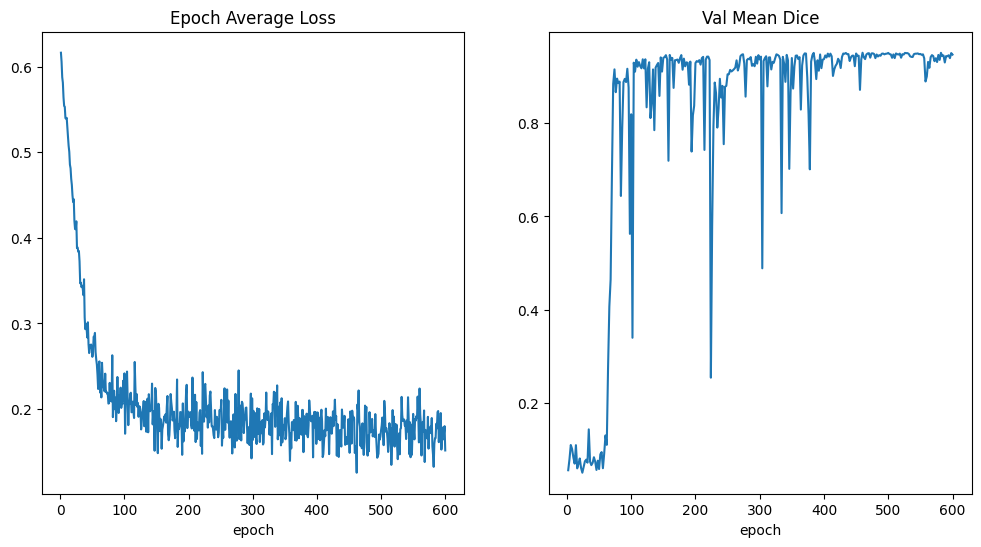

In [16]:
plt.figure('train', figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title('Val Mean Dice')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

### 3.2 学習済モデルの動作確認

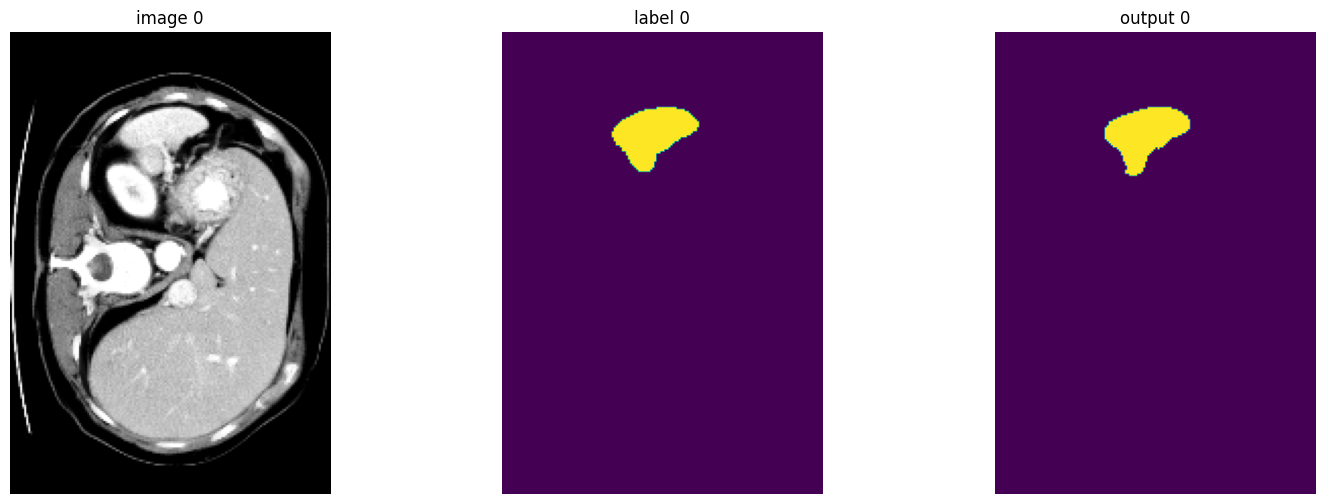

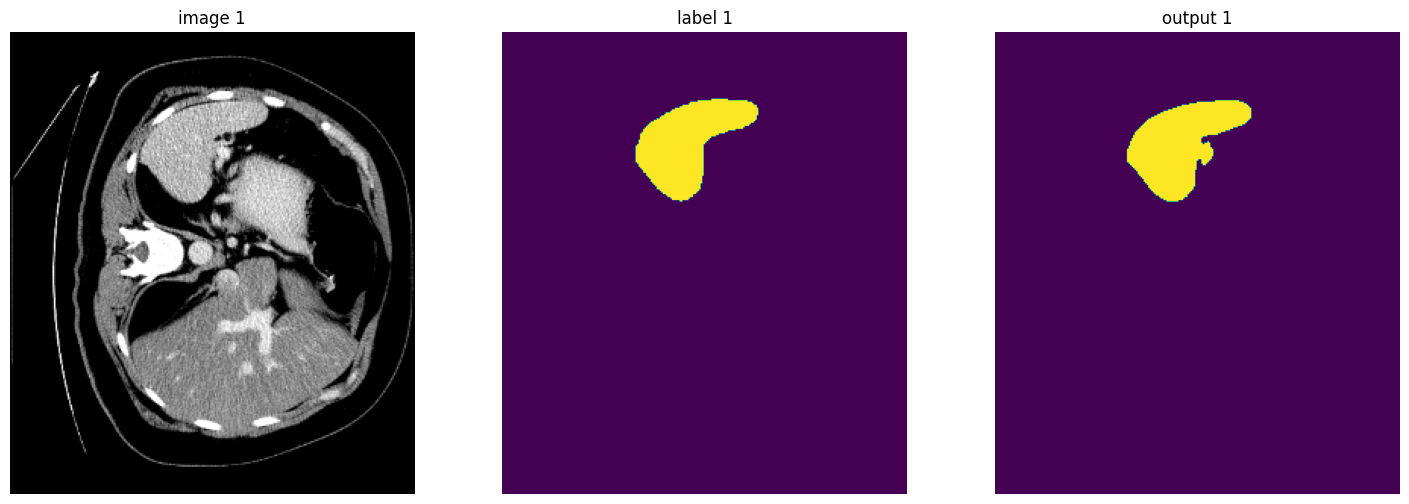

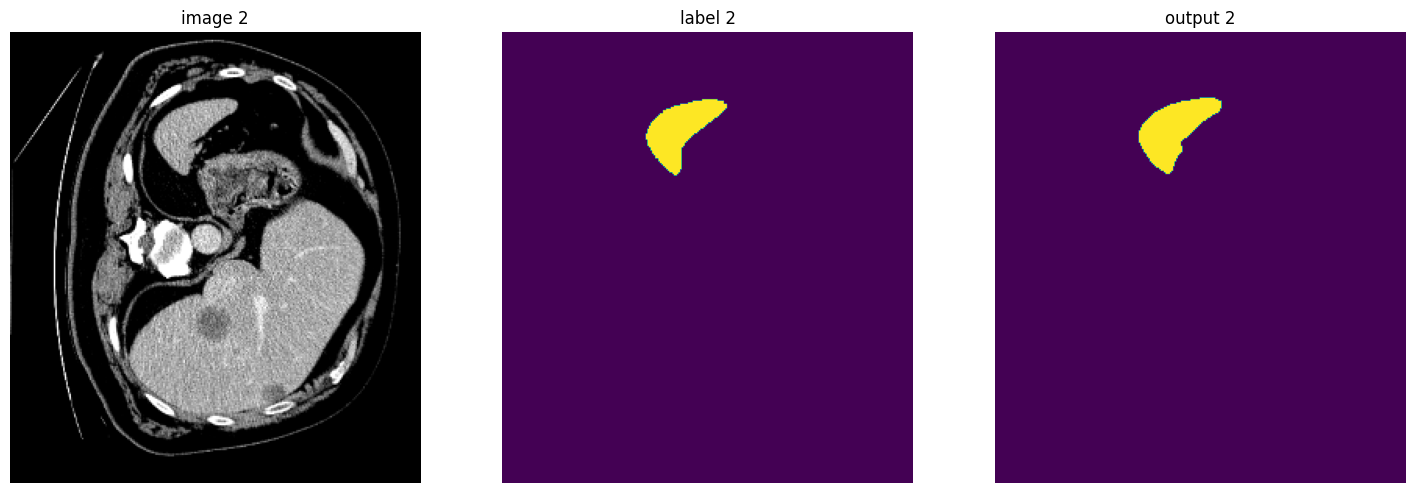

In [17]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_metric_model.pth')))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data['image'].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure('check', (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f'image {i}')
        plt.imshow(val_data['image'][0, 0, :, :, 80], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title(f'label {i}')
        plt.imshow(val_data['label'][0, 0, :, :, 80])
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title(f'output {i}')
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.axis('off')
        plt.show()
        
        if i == 2:
            break

## 4. 評価
### 4.1 評価の枠組み作成

In [18]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Orientationd(keys=['image'], axcodes='RAS'),
        Spacingd(keys=['image'], pixdim=(1.5, 1.5, 2.0), mode='bilinear'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=['image'], source_key='image'),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

In [19]:
post_transforms = Compose(
    [
        Invertd(
            keys='pred',
            transform=val_org_transforms,
            orig_keys='image',
            meta_keys='pred_meta_dict',
            orig_meta_keys='image_meta_dict',
            meta_key_postfix='meta_dict',
            nearest_interp=False,
            to_tensor=True,
            device='cpu',
        ),
        AsDiscreted(keys='pred', argmax=True, to_onehot=2),
        AsDiscreted(keys='label', to_onehot=2),
    ]
)

In [20]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_metric_model.pth')))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data['image'].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data['pred'] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(['pred', 'label'])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)
        
    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()
    
print('Metric on original image spacing: ', metric_org)

Metric on original image spacing:  0.963494598865509


### 4.2 テストセットの推論

In [21]:
test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*.nii.gz')))
test_data = [{'image': image} for image in test_images]

In [22]:
test_org_transforms = Compose(
    [
        LoadImaged(keys='image'),
        EnsureChannelFirstd(keys='image'),
        Orientationd(keys=['image'], axcodes='RAS'),
        Spacingd(keys=['image'], pixdim=(1.5, 1.5, 2.0), mode='bilinear'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=167, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image'], source_key='image'),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

In [23]:
post_transforms = Compose(
    [
        Invertd(
            keys='pred',
            transform=test_org_transforms,
            orig_keys='image',
            meta_keys='pred_meta_dict',
            orig_meta_keys='image_meta_dict',
            meta_key_postfix='meta_dict',
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys='pred', argmax=True, to_onehot=2),
        SaveImaged(keys='pred', meta_keys='pred_meta_dict', output_dir='./outputs/spleen', output_postfix='seg', resample=False),
    ]
)

In [24]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_metric_model.pth')))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data['image'].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data['pred'] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

2023-01-31 11:10:36,149 INFO image_writer.py:194 - writing: outputs/spleen/spleen_1/spleen_1_seg.nii.gz
2023-01-31 11:10:37,879 INFO image_writer.py:194 - writing: outputs/spleen/spleen_11/spleen_11_seg.nii.gz
2023-01-31 11:10:41,271 INFO image_writer.py:194 - writing: outputs/spleen/spleen_15/spleen_15_seg.nii.gz
2023-01-31 11:10:42,285 INFO image_writer.py:194 - writing: outputs/spleen/spleen_23/spleen_23_seg.nii.gz
2023-01-31 11:10:44,643 INFO image_writer.py:194 - writing: outputs/spleen/spleen_30/spleen_30_seg.nii.gz
2023-01-31 11:10:46,690 INFO image_writer.py:194 - writing: outputs/spleen/spleen_34/spleen_34_seg.nii.gz
2023-01-31 11:10:47,811 INFO image_writer.py:194 - writing: outputs/spleen/spleen_35/spleen_35_seg.nii.gz
2023-01-31 11:10:49,273 INFO image_writer.py:194 - writing: outputs/spleen/spleen_36/spleen_36_seg.nii.gz
2023-01-31 11:10:52,037 INFO image_writer.py:194 - writing: outputs/spleen/spleen_37/spleen_37_seg.nii.gz
2023-01-31 11:10:54,725 INFO image_writer.py:194